In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [2]:
# Загрузка и подготовка данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)

# нормализуем
x_train = x_train / 255.0
x_test = x_test / 255.0

# преобразуем метки в one-hot формат
y_train_hot = to_categorical(y_train, 10)
y_test_hot = to_categorical(y_test, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


In [3]:
# Функция построения модели
def build_model(hp):
    model = models.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Flatten(),
])

    model.add(layers.Dense(
        units=hp.Int('units_1', min_value=128, max_value=1024, step=64),
        activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(
        units=hp.Int('units_2', min_value=64, max_value=512, step=64),
        activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='fashion_mnist_mlp'
)

In [4]:
# Поиск
tuner.search(x_train, y_train_hot,
             epochs=10,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 10 Complete [00h 03m 44s]
val_accuracy: 0.824916660785675

Best val_accuracy So Far: 0.890916645526886
Total elapsed time: 00h 36m 06s


In [5]:
# Вывод лучших значений val_accuracy после завершения поиска
best_result = tuner.oracle.get_best_trials(num_trials=1)[0]
best_val_acc = best_result.metrics.get_last_value('val_accuracy')
print(f"Лучший val_accuracy: {best_val_acc:.4f}")

# Вывод лучших параметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшая конфигурация:\n"
      f"  units_1: {best_hps.get('units_1')}\n"
      f"  dropout_1: {best_hps.get('dropout_1'):.4f}\n"
      f"  units_2: {best_hps.get('units_2')}\n"
      f"  dropout_2: {best_hps.get('dropout_2'):.4f}\n"
      f"  learning_rate: {best_hps.get('learning_rate'):.4f}")

Лучший val_accuracy: 0.8909
Лучшая конфигурация:
  units_1: 768
  dropout_1: 0.4000
  units_2: 384
  dropout_2: 0.3000
  learning_rate: 0.0001


In [6]:
# обучение модели с лучшими параметрами
model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    x_train, y_train_hot,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.6423 - loss: 1.0435 - val_accuracy: 0.8353 - val_loss: 0.4669
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8276 - loss: 0.4995 - val_accuracy: 0.8543 - val_loss: 0.4104
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.8497 - loss: 0.4333 - val_accuracy: 0.8644 - val_loss: 0.3823
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8589 - loss: 0.3965 - val_accuracy: 0.8671 - val_loss: 0.3676
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8670 - loss: 0.3707 - val_accuracy: 0.8760 - val_loss: 0.3472
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8739 - loss: 0.3462 - val_accuracy: 0.8781 - val_loss: 0.3414
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.8782 - loss: 0.3370 - val_accuracy: 0.8804 - val_loss: 0.3295
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8824 - loss: 0.3229 - 

In [7]:
# Оценка модели
test_loss, test_acc = model.evaluate(x_test, y_test_hot)
print(f'\nРезультат точности: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8895 - loss: 0.3120

Результат точности: 0.8903


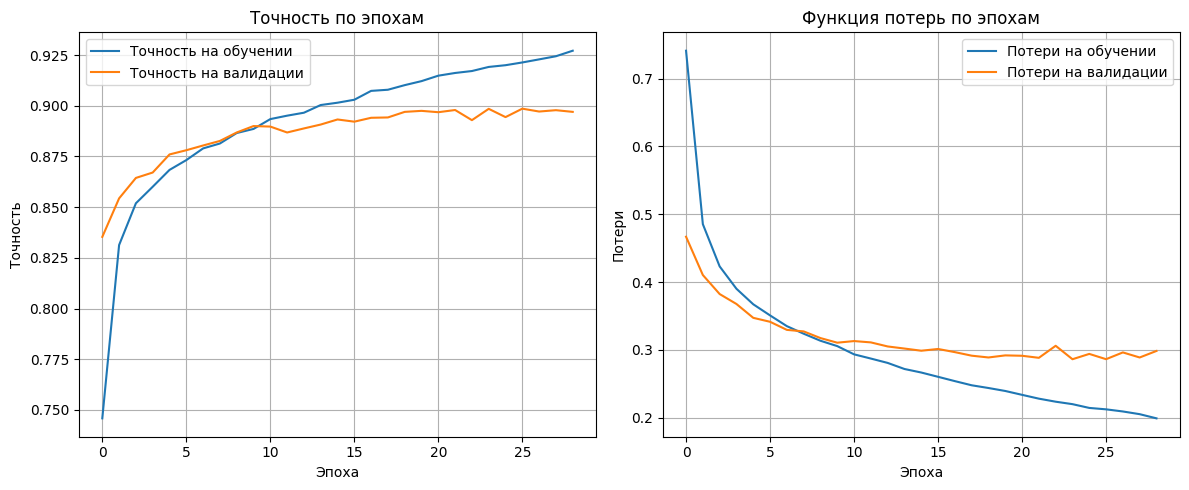

In [8]:
# Построение графиков точности и потерь
plt.figure(figsize=(12, 5))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Функция потерь по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()